In [1]:
!pip install transformers==2.5.1

     |████████████████████████████████| 501kB 500kB/s eta 0:00:01
     |████████████████████████████████| 880kB 11.2MB/s eta 0:00:01     |██████████▍                     | 286kB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 28.9MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.53-cp36-none-any.whl size=895254 sha256=26ca3fb0b486797330d89ee2a8a35e8f718e5ddf4000969ff9aa6780f4ecf08c
  Stored in directory: /root/.cache/pip/wheels/56/d5/b2/bc878b2bbddfbcc8fd62ca73c4fd842bd28c1fd3dbdf424c74
Successfully built sacremoses


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

The current versions of the fastai and transformers libraries are respectively 1.0.58 and 2.5.1.

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.58
transformers version : 2.5.1


In [4]:
# change file path to run
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")
print(train.shape,test.shape)
train.head()

(2690, 2) (1052, 2)


,Data,Label
0,Assumption: All commercial airlines are regula...,1
1,Assumption: All square shapes have four sides....,2
2,Assumption: All members of the House of Repres...,2
3,Assumption: All countries in Europe are locate...,2
4,Assumption: All savory foods contain salt. Ass...,2


In [63]:
train['Label'].value_counts()

1    1890
0     651
2     149
Name: Label, dtype: int64

In [64]:
train = train.drop(train.query('Label == 1').sample(frac=.6).index)

In [68]:
train['Label'].value_counts()

1    756
0    651
2    149
Name: Label, dtype: int64

In [69]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [70]:
# Parameters
seed = 42
use_fp16 = False
bs = 8

model_type = 'roberta'
pretrained_model_name = 'roberta-large'


In [71]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [72]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [73]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [74]:
seed_all(seed)

In [75]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [76]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [77]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [78]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [79]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [80]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [82]:
databunch = (TextList.from_df(train, cols='Data', processor=transformer_processor)
             .split_by_rand_pct(0.05,seed=seed)
             .label_from_df(cols= 'Label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [83]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> ĠAss umption : ĠAfter Ġan Ġaction Ġis Ġperformed Ġthings Ġnormally Ġremain Ġas Ġthey Ġwere . ĠAss umption : ĠAny Ġtime Ġthe Ġrobot Ġmar inates Ġa Ġchicken , Ġthe Ġchicken Ġwill Ġbe Ġin Ġthe Ġoven Ġtray . ĠAss umption : ĠIf Ġa Ġchicken Ġis Ġin Ġthe Ġoven Ġtray , Ġafter Ġthe Ġrobot Ġmoves Ġit Ġinto Ġthe Ġoven , Ġthe Ġchicken Ġwill Ġbe Ġin Ġthe Ġoven . ĠAss umption : ĠIf",1
"<s> ĠAss umption : ĠAfter Ġan Ġaction Ġis Ġperformed , Ġthings Ġnormally Ġremain Ġas Ġthey Ġwere . ĠAss umption : ĠA Ġtoy Ġis Ġon Ġthe Ġshelf Ġif Ġand Ġonly Ġif Ġit Ġis Ġnot Ġon Ġthe Ġfloor . ĠAss umption : ĠWhen ĠTim Ġgrabs Ġa Ġtoy , Ġthe Ġtoy Ġwill Ġnormally Ġbe Ġin Ġhis Ġhand . ĠAss umption : ĠWhen ĠTim Ġkeeps Ġa Ġtoy Ġon Ġthe Ġshelf , Ġthe Ġtoy Ġwill",1
"<s> ĠAss umption : ĠAfter Ġan Ġaction Ġis Ġperformed , Ġthings Ġnormally Ġremain Ġas Ġthey Ġwere . ĠAss umption : ĠA Ġtoy Ġis Ġon Ġthe Ġshelf Ġif Ġand Ġonly Ġif Ġit Ġis Ġnot Ġon Ġthe Ġfloor . ĠAss umption : ĠWhen ĠTim Ġgrabs Ġa Ġtoy , Ġthe Ġtoy Ġwill Ġnormally Ġbe Ġin Ġhis Ġhand . ĠAss umption : ĠWhen ĠTim Ġkeeps Ġa Ġtoy Ġon Ġthe Ġshelf , Ġthe Ġtoy Ġwill",0
"<s> ĠAss umption : ĠAfter Ġan Ġaction Ġis Ġperformed , Ġthings Ġnormally Ġremain Ġas Ġthey Ġwere . ĠAss umption : ĠThere Ġare Ġ2 Ġblocks Ġon Ġthe Ġfloor . ĠAss umption : ĠWhen Ġthe Ġrobot Ġgr as ps Ġa Ġblock , Ġthe Ġblock Ġwill Ġnormally Ġbe Ġin Ġthe Ġhand . ĠAss umption : ĠWhen Ġthe Ġrobot Ġmoves Ġa Ġblock Ġon Ġtop Ġof Ġanother Ġblock , Ġit Ġwill Ġmake Ġa Ġtower .",0
"<s> ĠAss umption : ĠAfter Ġan Ġaction Ġis Ġperformed , Ġthings Ġnormally Ġremain Ġas Ġthey Ġwere . ĠAss umption : ĠA Ġtoy Ġis Ġon Ġthe Ġshelf Ġif Ġand Ġonly Ġif Ġit Ġis Ġnot Ġon Ġthe Ġfloor . ĠAss umption : ĠWhen ĠTim Ġgrabs Ġa Ġtoy , Ġthe Ġtoy Ġwill Ġnormally Ġbe Ġin Ġhis Ġhand . ĠAss umption : ĠWhen ĠTim Ġkeeps Ġa Ġtoy Ġon Ġthe Ġshelf , Ġthe Ġtoy Ġwill",0


Check batch and numericalizer :

In [84]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([8, 182])
tensor([[    0,  6331, 21236,  ..., 12941,     4,     2],
        [    0,  6331, 21236,  ...,     1,     1,     1],
        [    0,  6331, 21236,  ...,     1,     1,     1],
        ...,
        [    0,  6331, 21236,  ...,     1,     1,     1],
        [    0,  6331, 21236,  ...,     1,     1,     1],
        [    0,  6331, 21236,  ...,     1,     1,     1]])


In [85]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [86]:
train['Label'].value_counts()

1    756
0    651
2    149
Name: Label, dtype: int64

In [87]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 3
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_id": 2,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_beams": 1,
  "num_hidden_layers": 24,
  "num_labels": 3,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_

In [88]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [89]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()
    

In [90]:


# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

Check groups : 

In [91]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 1024, padding_idx=1)
  (1): Embedding(514, 1024, padding_idx=1)
  (2): Embedding(1, 1024)
  (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=1024, bias=True)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=1024, out_features=4096, bias=True)
  (8): Linear(in_features=4096, out_features=1024, bias=True)
  (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=10

In [ ]:
learner.save('untrain')

In [93]:
seed_all(seed)
learner.load('untrain');

In [94]:
learner.freeze_to(-1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.281595,0.966582,0.493506,0.506494,00:13


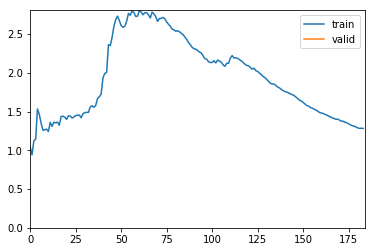

In [95]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [96]:
learner.save('first_cycle')

In [97]:
seed_all(seed)
learner.load('first_cycle');

In [98]:
learner.freeze_to(-2)

In [99]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.895997,0.922502,0.532468,0.467532,00:30


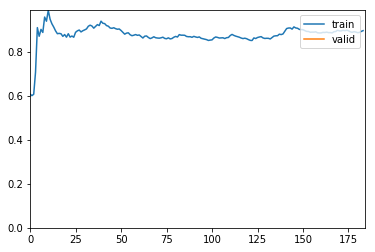

In [100]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [101]:
learner.save('second_cycle')

In [102]:
seed_all(seed)
learner.load('second_cycle');

In [103]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.791957,0.690849,0.753247,0.246753,00:32


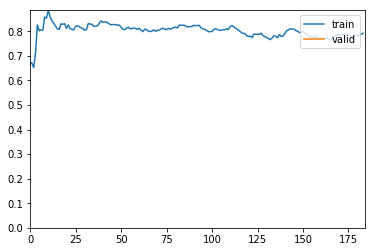

In [104]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [105]:
learner.save('third_cycle')

In [106]:
seed_all(seed)
learner.load('third_cycle');

In [107]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.624563,0.762338,0.714286,0.285714,00:47
1,0.634388,0.521433,0.805195,0.194805,00:45
2,0.460398,0.654085,0.753247,0.246753,00:49
3,0.321590,0.709715,0.753247,0.246753,00:45
4,0.156167,0.656757,0.831169,0.168831,00:45
5,0.098996,0.725606,0.831169,0.168831,00:45


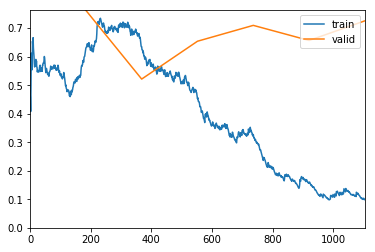

In [108]:
learner.fit_one_cycle(6, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [110]:
ret = learner.get_preds(ds_type=DatasetType.Test)

In [111]:
preds = []
for i in ret[0]:
    preds.append(int(torch.argmax(i)))

In [112]:
y_true = test["Label"].values

In [113]:
y_sent = test["Data"].values

In [114]:
get = learner.predict(y_sent[3])

In [116]:
preddd = []
for i in y_sent:
    get = learner.predict(i)
    preddd.append(int(get[1]))


In [117]:
test["Label"].value_counts()

1    682
0    263
2    107
Name: Label, dtype: int64

In [118]:

zer = 0
one = 0
two = 0
zer_c = 0
one_c = 0
two_c = 0
for i in range(len(preddd)):
    if(y_true[i]==0):
        zer+=1
        if(y_true[i]==preddd[i]):
            zer_c+=1
    if(y_true[i]==1):
        one+=1
        if(y_true[i]==preddd[i]):
            one_c+=1
    if(y_true[i]==2):
        two+=1
        if(y_true[i]==preddd[i]):
            two_c+=1


In [120]:
#False accuracy
zer_c/zer

0.6615969581749049

In [121]:
#True accuracy
one_c/one

0.8768328445747801

In [122]:
#Undetermined accuracy
two_c/two

0.4485981308411215

In [125]:
#overall accuracy
(one_c+zer_c+two_c)/(one+two+zer)

0.779467680608365